# Data prep: Simple CNN

**Author:** Yifei Hang (UW Varanasi intern 2024) and adapted by Eli Holmes


This notebook shows how to create a data set ready for sending to ML models. We will send the data to our models as `xarray` objects (which are numpy arrays with metadata added).

In [1]:
import xarray as xr
import numpy as np

In [2]:
zarr_ds = xr.open_zarr("~/shared-public/mind_the_chl_gap/IO.zarr")
zarr_sliced = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))
all_nan_CHL = np.isnan(zarr_sliced["CHL_cmes-level3"]).all(dim=["lon", "lat"]).compute()  # find sample indices where CHL is NaN
zarr_CHL = zarr_sliced.sel(time=(all_nan_CHL == False))  # select samples with CHL not NaN
zarr_CHL = zarr_CHL.sortby('time')
zarr_CHL = zarr_CHL.sel(time=slice('2020-01-01', '2020-12-31'))
zarr_CHL

<xarray.Dataset> Size: 958MB
Dimensions:                       (time: 366, lat: 149, lon: 181)
Coordinates:
  * lat                           (lat) float32 596B 32.0 31.75 ... -4.75 -5.0
  * lon                           (lon) float32 724B 45.0 45.25 ... 89.75 90.0
  * time                          (time) datetime64[ns] 3kB 2020-01-01 ... 20...
Data variables: (12/27)
    CHL                           (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    CHL_cmes-cloud                (time, lat, lon) uint8 10MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    CHL_cmes-gapfree              (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    CHL_cmes-land                 (lat, lon) uint8 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    CHL_cmes-level3               (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    CHL_cmes_flags-gapfree        (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    ...                            ...
    ug_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    v_curr                        (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    v_wind                        (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    vg_curr                       (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    wind_dir                      (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
    wind_speed                    (time, lat, lon) float32 39MB dask.array<chunksize=(39, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

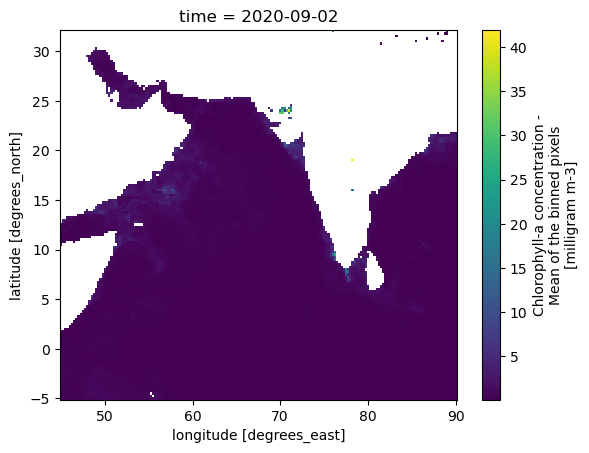

In [9]:
p = zarr_CHL.sel(time='2020-09-02').CHL.plot(y='lat', x='lon')

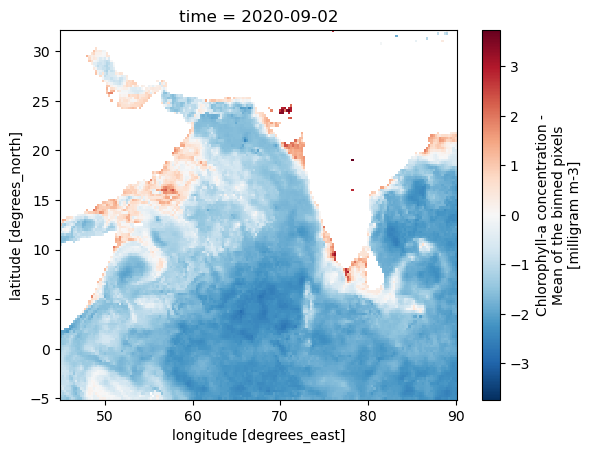

In [10]:
# log scale
np.log(zarr_CHL.sel(time='2020-09-02').CHL).plot(y='lat', x='lon')

## Process the data

We need to split into our training and testing data.

In [11]:
def log_label(data, label):
    data_logged = data.copy()
    data_logged[label] = np.log(data[label]).copy()
    return data_logged

# Add more preprocessing later
def preprocess_data(data, features, label):
    # sel_data = data[features + label]
    # sel_data = da.where(da.isnan(sel_data), 0.0, sel_data)
    data_logged = log_label(data, label)

    sel_data_list = []
    for var in (features + [label]):
        sel_var_data = data_logged[var]
        sel_var_data = da.where(da.isnan(sel_var_data), 0.0, sel_var_data)
        sel_data_list.append(sel_var_data)
        # print(data[var]).shape
    # sel_data_da = da.from_array(sel_data_arr)
    # sel_data = da.where(da.isnan(sel_data_da), 0.0, sel_data_da)
    sel_data_da =  da.array(sel_data_list)
    # sel_data_da = np.moveaxis(sel_data_da, 0, -1)
    return sel_data_da

def time_series_split(data, split_ratio):
    X = data[:-1]
    y = data[-1]
    
    X = np.moveaxis(X, 0, -1)

    total_length = X.shape[0]
    
    train_end = int(total_length * split_ratio[0])
    val_end = int(total_length * (split_ratio[0] + split_ratio[1]))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end: val_end], y[train_end: val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return (X_train, y_train,
            X_val, y_val,
            X_test, y_test)


Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

In [13]:
 # Curr Features: Sea Surface Temp (K), Sea Salinity Concentration (m**-3 or PSL). [Excluding Topography/Bathymetry (m)]
features = ['sst', 'so'] 
label = 'CHL_cmes-level3'  # chlorophyll-a concentration (mg/m**3) [Not taking uncertainty into consideration for now]
model_data = preprocess_data(zarr_CHL, features, label)

split_ratio = [.7, .2, .1]
X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(model_data, split_ratio)